In [12]:
import os
dataset_path = 'D:\DOWNLOADS\DDD\c-spine_nor'
st=set()

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        file_extension = pathlib.Path(filename).suffix
        st.add(file_extension)

In [9]:
print(st)
 


{'.129904247d,kytJPG', '.JPG', '.jpeg', '.jpg'}


In [11]:
print(st)

{'.JPG', '.jpg', '.jpeg'}


In [13]:
print(st)

{'.JPG', '.jpg'}


In [ ]:
('.129904247d,kytJPG', '.JPG', '.jpeg', '.jpg','.JPG', '.jpg', '.jpeg')

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import ExifTags
from PIL import Image
import os

input_size = (224, 224)

# Path to your dataset folders (normal, dislocation, fractured)
dataset_path = 'D:/DOWNLOADS/DDD'

# Path to save resized and converted RGB images
output_path = 'D:/ODT'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        # Check if the file is an image based on its extension
        if filename.lower().endswith(( '.JPG', '.jpeg', '.jpg','.JPG', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            img = Image.open(image_path).convert("RGB")  # Convert to RGB format
            img = img.resize(input_size, Image.LANCZOS)  # Resize using Lanczos
            # Create subdirectories if they don't exist in the output directory
            output_subdir = os.path.join(output_path, os.path.relpath(root, dataset_path))
            os.makedirs(output_subdir, exist_ok=True)
            img.save(os.path.join(output_subdir, filename))


In [18]:
base_dir = 'D:/TDT'
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

In [19]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


In [21]:
import random
import shutil

for class_name in os.listdir('D:/ODT'):
    class_path = os.path.join('D:/ODT', class_name)
    images = os.listdir(class_path)
    num_images = len(images)
    random.shuffle(images)

    train_split = int(train_ratio * num_images)
    val_split = int(val_ratio * num_images)

    # Copy images to the corresponding split directories
    for i, image in enumerate(images):
        src_path = os.path.join(class_path, image)
        if i < train_split:
            dst_dir = os.path.join(base_dir, 'train', class_name)
        elif i < train_split + val_split:
            dst_dir = os.path.join(base_dir, 'val', class_name)
        else:
            dst_dir = os.path.join(base_dir, 'test', class_name)
        
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, os.path.join(dst_dir, image))


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 10

train_generator = train_datagen.flow_from_directory(
    'D:/NDT/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'D:/NDT/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'D:/NDT/test',
    shuffle=False,  
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1405 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 304 images belonging to 3 classes.


In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify input shape and number of classes
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 3  # Adjust for your classification task

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Create your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer and a specific learning rate
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])


# Train your model with your dataset
# model.fit(train_generator, epochs=epochs, validation_data=val_generator)
model.fit(train_generator, epochs=30, batch_size=10, validation_data=validation_generator)
# Make sure to load your dataset and train the model with the appropriate data and labels.
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/30
141/141 [==============================] - 70s 471ms/step - loss: 0.5675 - accuracy: 0.7644 - val_loss: 0.2584 - val_accuracy: 0.9033
Epoch 2/30
141/141 [==============================] - 63s 448ms/step - loss: 0.0887 - accuracy: 0.9779 - val_loss: 0.0671 - val_accuracy: 0.9833
Epoch 3/30
141/141 [==============================] - 62s 437ms/step - loss: 0.0691 - accuracy: 0.9836 - val_loss: 0.0457 - val_accuracy: 0.9933
Epoch 4/30
141/141 [==============================] - 61s 433ms/step - loss: 0.0463 - accuracy: 0.9900 - val_loss: 0.0310 - val_accuracy: 0.9933
Epoch 5/30
141/141 [==============================] - 61s 433ms/step - loss: 0.0577 - accuracy: 0.9879 - val_loss: 0.0345 - val_accuracy: 0.9933
Epoch 6/30
141/141 [==============================] - 61s 434ms/step - loss: 0.0461 - accuracy: 0.9900 - val_loss: 0.0302 - val_accuracy: 0.9933
Epoch 7/30
141/141 [==============================] - 61s 434ms/step - loss: 0.0372 - accuracy: 0.9893 - val_loss: 0.0279 - val_ac

In [14]:
tf.keras.models.save_model(model,'Test3.hdf5')

C:\Users\swapn\AppData\Local\Temp\ipykernel_15636\1760233539.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'Test3.hdf5')


In [21]:
model = tf.keras.models.load_model('Test.hdf5')

31/31 [==============================] - 15s 389ms/step - loss: 0.0230 - accuracy: 0.9934
Test accuracy: 99.34%


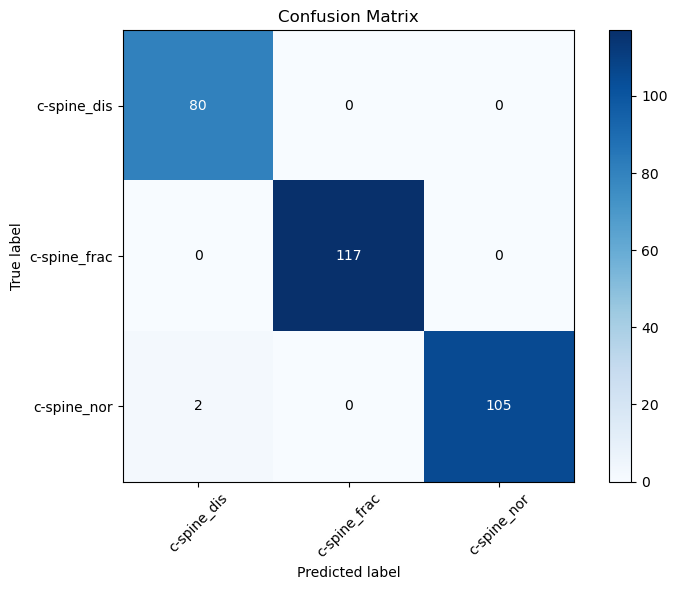

In [22]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
# Get true labels
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels and tick marks
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Display values in each cell
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [8]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
print(predictions)

31/31 [==============================] - 10s 333ms/step
[[1.05939100e-04 2.96057824e-05 9.99864459e-01]
 [4.03620739e-04 9.99303102e-01 2.93310644e-04]
 [1.65934663e-03 2.77969521e-04 9.98062670e-01]
 [9.97811735e-01 1.58460563e-04 2.02988274e-03]
 [1.51314147e-04 2.92945879e-05 9.99819458e-01]
 [9.99800503e-01 1.83920725e-04 1.55797698e-05]
 [3.89346678e-04 4.44479956e-04 9.99166250e-01]
 [9.99538660e-01 9.02270913e-05 3.71187722e-04]
 [9.98627543e-01 3.73788612e-06 1.36883615e-03]
 [2.30210826e-05 9.98360932e-01 1.61612721e-03]
 [9.99602735e-01 3.94918665e-04 2.41518092e-06]
 [9.99514937e-01 1.33602225e-04 3.51544470e-04]
 [4.57663264e-05 9.99541759e-01 4.12543246e-04]
 [9.00357496e-04 5.82420353e-06 9.99093890e-01]
 [9.98141289e-01 2.76820734e-04 1.58199680e-03]
 [9.97741938e-01 7.96712353e-04 1.46136316e-03]
 [7.68531580e-04 1.40191565e-04 9.99091268e-01]
 [1.86279605e-04 2.17050686e-03 9.97643173e-01]
 [1.86279605e-04 2.17050686e-03 9.97643173e-01]
 [3.86517262e-03 1.09073566e-03 

In [14]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [15]:
from tensorflow.keras import backend as K
K.clear_session()
